Wczytanie danych

In [ ]:
import pandas as pd

columns = ['user_id', 'item_id', 'rating', 'timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=columns)

print(ratings.head())


ratings = ratings.drop('timestamp', axis=1)

num_users = ratings['user_id'].nunique()
num_items = ratings['item_id'].nunique()
print(f"Liczba użytkowników: {num_users}, Liczba filmów: {num_items}")


   user_id  item_id  rating  timestamp
0      196      242       3  881250949
1      186      302       3  891717742
2       22      377       1  878887116
3      244       51       2  880606923
4      166      346       1  886397596
Liczba użytkowników: 943, Liczba filmów: 1682


Tworzenie macierzy użytkownik-film:

In [3]:
user_item_matrix = ratings.pivot(index='user_id', columns='item_id', values='rating')

# Podgląd macierzy
print(user_item_matrix.head())

# Zapisanie macierzy do pliku CSV
user_item_matrix.to_csv('user_item_matrix.csv')


item_id  1     2     3     4     5     6     7     8     9     10    ...  \
user_id                                                              ...   
1         5.0   3.0   4.0   3.0   3.0   5.0   4.0   1.0   5.0   3.0  ...   
2         4.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   2.0  ...   
3         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
4         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
5         4.0   3.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   

item_id  1673  1674  1675  1676  1677  1678  1679  1680  1681  1682  
user_id                                                              
1         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
3         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
4         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
5         NaN   NaN   NaN   NaN   NaN   NaN   N

Sprawdzenie danych:

In [4]:
print(user_item_matrix.isna().sum().sum())


1486126


Opcjonalna normlaizacja ocen

In [5]:
user_item_matrix_normalized = user_item_matrix.subtract(user_item_matrix.mean(axis=1), axis=0)


Przykład faktoryzacji macierzy

In [ ]:
import numpy as np

# Ustawienia
num_users, num_items = user_item_matrix.shape
num_features = 10  # Liczba ukrytych wymiarów
learning_rate = 0.01
reg_param = 0.1  # Parametr regularyzacji
epochs = 100

# Inicjalizacja macierzy P i Q
P = np.random.normal(scale=1./num_features, size=(num_users, num_features))
Q = np.random.normal(scale=1./num_features, size=(num_items, num_features))

# Konwersja macierzy na NumPy
ratings = user_item_matrix.to_numpy()

# SGD
for epoch in range(epochs):
    for i in range(num_users):
        for j in range(num_items):
            if not np.isnan(ratings[i, j]):
                error = ratings[i, j] - np.dot(P[i, :], Q[j, :].T)
                for k in range(num_features):
                    P[i, k] += learning_rate * (error * Q[j, k] - reg_param * P[i, k])
                    Q[j, k] += learning_rate * (error * P[i, k] - reg_param * Q[j, k])

    # Obliczanie straty 
    loss = 0
    for i in range(num_users):
        for j in range(num_items):
            if not np.isnan(ratings[i, j]):
                loss += (ratings[i, j] - np.dot(P[i, :], Q[j, :].T))**2
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}")

# Wynikowa macierz
predicted_ratings = np.dot(P, Q.T)


Dodano kod testujący

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# Wczytanie danych
ratings_train = pd.read_csv('ml-100k/u1.base', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
ratings_test = pd.read_csv('ml-100k/u1.test', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])

# Parametry macierzy
num_users = ratings_train['user_id'].nunique()
num_items = ratings_train['item_id'].nunique()
num_features = 10  # Liczba ukrytych wymiarów
learning_rate = 0.01
reg_param = 0.1  # Parametr regularyzacji
epochs = 100

# Tworzenie macierzy użytkownik-film
train_matrix = ratings_train.pivot(index='user_id', columns='item_id', values='rating')
train_matrix = train_matrix.to_numpy()

# Inicjalizacja macierzy P i Q
P = np.random.normal(scale=1./num_features, size=(num_users, num_features))
Q = np.random.normal(scale=1./num_features, size=(num_items, num_features))

# Faktoryzacja macierzy (SGD)
for epoch in range(epochs):
    for i in range(num_users):
        for j in range(num_items):
            if not np.isnan(train_matrix[i, j]):  # Pomijamy brakujące oceny
                error = train_matrix[i, j] - np.dot(P[i, :], Q[j, :].T)
                for k in range(num_features):
                    P[i, k] += learning_rate * (error * Q[j, k] - reg_param * P[i, k])
                    Q[j, k] += learning_rate * (error * P[i, k] - reg_param * Q[j, k])

# Wynikowa macierz
predicted_ratings = np.dot(P, Q.T)

# Sprawdzanie jakości na zbiorze testowym
test_ratings = []
predicted_test_ratings = []

for _, row in ratings_test.iterrows():
    user = row['user_id'] - 1  # Indeksy w zbiorze zaczynają się od 1
    item = row['item_id'] - 1
    true_rating = row['rating']
    predicted_rating = predicted_ratings[user, item]
    
    test_ratings.append(true_rating)
    predicted_test_ratings.append(predicted_rating)

# Obliczanie błędu MSE
mse = mean_squared_error(test_ratings, predicted_test_ratings)
print(f"Mean Squared Error (MSE) na zbiorze testowym: {mse:.4f}")


Epoch 1/50, Loss: 727023.0338
Epoch 2/50, Loss: 195330.9757
Epoch 3/50, Loss: 94376.2321
Epoch 4/50, Loss: 80815.2154
Epoch 5/50, Loss: 76244.9106
Epoch 6/50, Loss: 73930.3231
Epoch 7/50, Loss: 72504.2895
Epoch 8/50, Loss: 71487.7586
Epoch 9/50, Loss: 70668.1394
Epoch 10/50, Loss: 69934.5358
Epoch 11/50, Loss: 69224.1667
Epoch 12/50, Loss: 68503.4934
Epoch 13/50, Loss: 67761.1566
Epoch 14/50, Loss: 67003.0579
Epoch 15/50, Loss: 66245.3947
Epoch 16/50, Loss: 65506.1589
Epoch 17/50, Loss: 64798.4387
Epoch 18/50, Loss: 64127.8985
Epoch 19/50, Loss: 63493.9020
Epoch 20/50, Loss: 62892.1454
Epoch 21/50, Loss: 62317.0845
Epoch 22/50, Loss: 61763.5051
Epoch 23/50, Loss: 61227.2863
Epoch 24/50, Loss: 60705.6145
Epoch 25/50, Loss: 60196.8862
Epoch 26/50, Loss: 59700.4604
Epoch 27/50, Loss: 59216.3645
Epoch 28/50, Loss: 58745.0158
Epoch 29/50, Loss: 58286.9960
Epoch 30/50, Loss: 57842.8918
Epoch 31/50, Loss: 57413.1992
Epoch 32/50, Loss: 56998.2790
Epoch 33/50, Loss: 56598.3449
Epoch 34/50, Loss

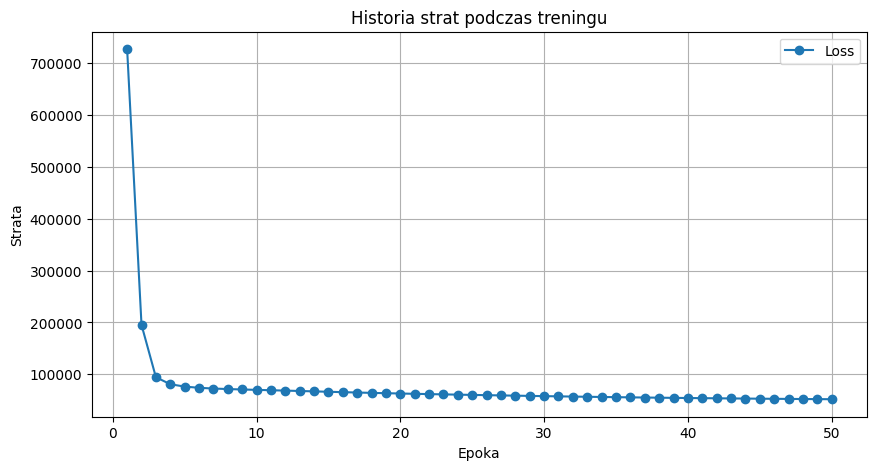

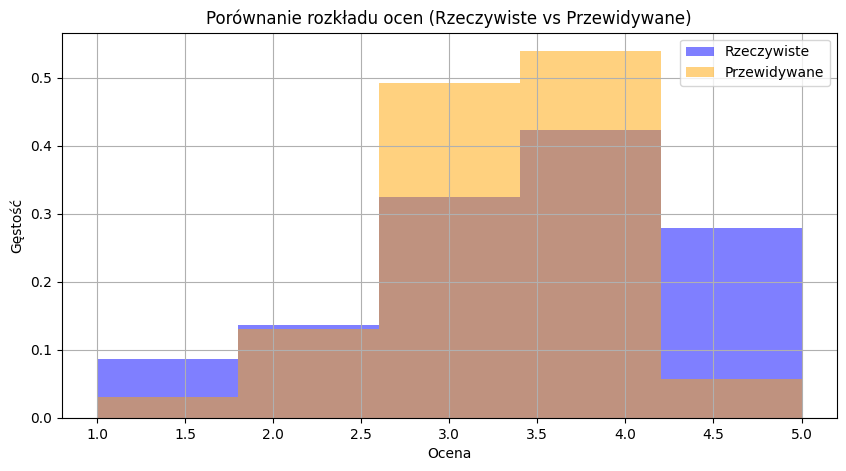

In [10]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, accuracy_score
import matplotlib.pyplot as plt

# Wczytanie danych
ratings_train = pd.read_csv('ml-100k/u1.base', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
ratings_test = pd.read_csv('ml-100k/u1.test', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])

# Parametry macierzy
num_users = ratings_train['user_id'].nunique()
num_items = ratings_train['item_id'].nunique()
num_features = 10  # Liczba ukrytych wymiarów
learning_rate = 0.01
reg_param = 0.1  # Parametr regularyzacji
epochs = 50  # Zmniejszona liczba epok dla szybszego treningu

# Tworzenie macierzy użytkownik-film
train_matrix = ratings_train.pivot(index='user_id', columns='item_id', values='rating')
train_matrix = train_matrix.to_numpy()

# Inicjalizacja macierzy P i Q
P = np.random.normal(scale=1./num_features, size=(num_users, num_features))
Q = np.random.normal(scale=1./num_features, size=(num_items, num_features))

# Faktoryzacja macierzy (SGD)
loss_history = []  # Historia strat dla wizualizacji
for epoch in range(epochs):
    loss = 0
    for i in range(num_users):
        for j in range(num_items):
            if not np.isnan(train_matrix[i, j]):  # Pomijamy brakujące oceny
                error = train_matrix[i, j] - np.dot(P[i, :], Q[j, :].T)
                loss += error**2
                for k in range(num_features):
                    P[i, k] += learning_rate * (error * Q[j, k] - reg_param * P[i, k])
                    Q[j, k] += learning_rate * (error * P[i, k] - reg_param * Q[j, k])
    loss_history.append(loss)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}")

# Wynikowa macierz
predicted_ratings = np.dot(P, Q.T)

# Sprawdzanie jakości na zbiorze testowym
test_ratings = []
predicted_test_ratings = []

for _, row in ratings_test.iterrows():
    user = row['user_id'] - 1  # Indeksy w zbiorze zaczynają się od 1
    item = row['item_id'] - 1
    true_rating = row['rating']
    predicted_rating = np.clip(predicted_ratings[user, item], 1, 5)  # Przycięcie do skali 1-5
    
    test_ratings.append(true_rating)
    predicted_test_ratings.append(round(predicted_rating))  # Zaokrąglenie do najbliższej oceny

# Obliczanie błędu MSE
mse = mean_squared_error(test_ratings, predicted_test_ratings)
print(f"Mean Squared Error (MSE) na zbiorze testowym: {mse:.4f}")

# Obliczanie accuracy
accuracy = accuracy_score(test_ratings, predicted_test_ratings)
print(f"Accuracy na zbiorze testowym: {accuracy:.4f}")

# Wizualizacja strat
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), loss_history, marker='o', label='Loss')
plt.title('Historia strat podczas treningu')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.grid()
plt.legend()
plt.show()

# Histogram rzeczywistych vs przewidywanych ocen
plt.figure(figsize=(10, 5))
plt.hist(test_ratings, bins=5, alpha=0.5, label='Rzeczywiste', color='blue', density=True)
plt.hist(predicted_test_ratings, bins=5, alpha=0.5, label='Przewidywane', color='orange', density=True)
plt.title('Porównanie rozkładu ocen (Rzeczywiste vs Przewidywane)')
plt.xlabel('Ocena')
plt.ylabel('Gęstość')
plt.legend()
plt.grid()
plt.show()


Próba update

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, accuracy_score
import matplotlib.pyplot as plt

# Wczytanie danych
ratings_train = pd.read_csv('ml-100k/u1.base', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
ratings_test = pd.read_csv('ml-100k/u1.test', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])

# Parametry macierzy
num_users = ratings_train['user_id'].nunique()
num_items = ratings_train['item_id'].nunique()
num_features = 15  # Zwiększona liczba ukrytych wymiarów
learning_rate = 0.005  # Mniejsza szybkość uczenia
reg_param = 0.2  # Silniejsza regularyzacja
epochs = 100  # Więcej epok

# Tworzenie macierzy użytkownik-film
train_matrix = ratings_train.pivot(index='user_id', columns='item_id', values='rating').to_numpy()

# Normalizacja ocen: Odejmujemy średnią ocen użytkownika
user_mean = np.nanmean(train_matrix, axis=1, keepdims=True)
train_matrix_normalized = train_matrix - user_mean
train_matrix_normalized[np.isnan(train_matrix_normalized)] = 0  # Wstawienie zer w brakujące miejsca

# Inicjalizacja macierzy P i Q
P = np.random.normal(scale=1./num_features, size=(num_users, num_features))
Q = np.random.normal(scale=1./num_features, size=(num_items, num_features))

# Faktoryzacja macierzy (SGD)
loss_history = []  # Historia strat dla wizualizacji
for epoch in range(epochs):
    loss = 0
    for i in range(num_users):
        for j in range(num_items):
            if not np.isnan(train_matrix[i, j]):  # Pomijamy brakujące oceny
                error = train_matrix_normalized[i, j] - np.dot(P[i, :], Q[j, :].T)
                loss += error**2
                for k in range(num_features):
                    P[i, k] += learning_rate * (error * Q[j, k] - reg_param * P[i, k])
                    Q[j, k] += learning_rate * (error * P[i, k] - reg_param * Q[j, k])
    loss_history.append(loss)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}")

# Wynikowa macierz
predicted_ratings = np.dot(P, Q.T) + user_mean  # Dodanie średniej ocen użytkownika

# Sprawdzanie jakości na zbiorze testowym
test_ratings = []
predicted_test_ratings = []

for _, row in ratings_test.iterrows():
    user = row['user_id'] - 1  # Indeksy w zbiorze zaczynają się od 1
    item = row['item_id'] - 1
    true_rating = row['rating']
    predicted_rating = np.clip(predicted_ratings[user, item], 1, 5)  # Przycięcie do skali 1-5
    
    test_ratings.append(true_rating)
    predicted_test_ratings.append(round(predicted_rating))  # Zaokrąglenie do najbliższej oceny

# Obliczanie błędu MSE
mse = mean_squared_error(test_ratings, predicted_test_ratings)
print(f"Mean Squared Error (MSE) na zbiorze testowym: {mse:.4f}")

# Obliczanie accuracy
accuracy = accuracy_score(test_ratings, predicted_test_ratings)
print(f"Accuracy na zbiorze testowym: {accuracy:.4f}")

# Wizualizacja strat
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), loss_history, marker='o', label='Loss')
plt.title('Historia strat podczas treningu')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.grid()
plt.legend()
plt.show()

# Histogram rzeczywistych vs przewidywanych ocen
plt.figure(figsize=(10, 5))
plt.hist(test_ratings, bins=5, alpha=0.5, label='Rzeczywiste', color='blue', density=True)
plt.hist(predicted_test_ratings, bins=5, alpha=0.5, label='Przewidywane', color='orange', density=True)
plt.title('Porównanie rozkładu ocen (Rzeczywiste vs Przewidywane)')
plt.xlabel('Ocena')
plt.ylabel('Gęstość')
plt.legend()
plt.grid()
plt.show()
